In [78]:
from pathlib import Path
import json
from collections import Counter
import pandas as pd
import os
import re
import random, cv2
import matplotlib.pyplot as plt
import json
import re

In [64]:
%matplotlib inline

In [65]:
print(os.getcwd())

C:\Users\lisan\Jupyter Notebook Projects\Recycling-YOLO\notebooks


In [66]:
ANN_PATH = Path("../data/raw/taco/annotations.json")
IMG_DIR = Path("../data/raw/taco/images")

In [67]:
coco = json.loads(ANN_PATH.read_text())
id_to_img = {im["id"]: im for im in coco["images"]}
id_to_cat = {c["id"]: c["name"] for c in coco["categories"]}

In [68]:
cat_counts = Counter(id_to_cat[a["category_id"]] for a in coco["annotations"])
df_cats = (pd.DataFrame({"category": list(cat_counts.keys()), "count": list(cat_counts.values())})
           .sort_values("count", ascending=False)
           .reset_index(drop=True))
df_cats.head(25) 

,category,count
0,Cigarette,667
1,Unlabeled litter,517
2,Plastic film,451
3,Clear plastic bottle,285
4,Other plastic,273
5,Other plastic wrapper,260
6,Drink can,229
7,Plastic bottle cap,209
8,Plastic straw,157
9,Broken glass,138


Unique categories: 59


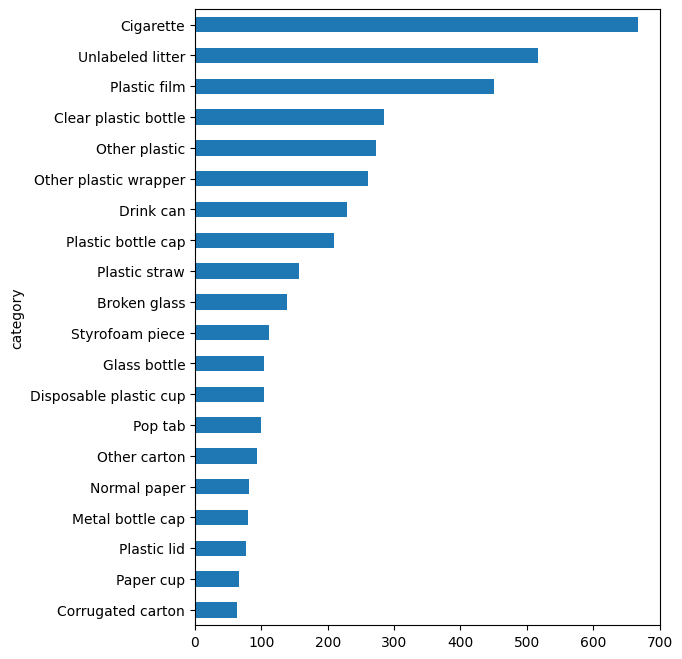

In [69]:
print("Unique categories:", df_cats.shape[0])
ax = df_cats.head(20).plot(kind="barh", x="category", y="count", figsize=(6,8), legend=False)
ax.invert_yaxis()

In [70]:
TARGET_NAMES = ["plastic_bottle", "aluminum_can", "glass_bottle", "metal_can", "other_plastic", "plastic_film"]

In [71]:
def norm(s): 
    return re.sub(r"\s+", " ", s.strip().lower())

def map_category(cat_name: str):
    c = norm(cat_name)
    # bottles
    if "bottle" in c:
        if "glass" in c:   return "glass_bottle"
        if "plastic" in c: return "plastic_bottle"
        # default bottle → plastic in this v1
        return "plastic_bottle"
    # cans
    if "can" in c:
        if "aluminium" in c or "aluminum" in c:
            return "aluminum_can"
        return "metal_can"
    #other plastic
    if "other" in c:
        if "plastic" in c:
            return "other_plastic"
    #plastic film
    if "film" in c:
        if "plastic" in c:
            return "plastic_film"

    # drop all other litter types in v1
    return None

In [72]:
mapped = [map_category(id_to_cat[a["category_id"]]) for a in coco["annotations"]]
pd.Series([m for m in mapped if m is not None]).value_counts()

plastic_bottle    624
other_plastic     541
plastic_film      451
metal_can         263
glass_bottle      104
Name: count, dtype: int64

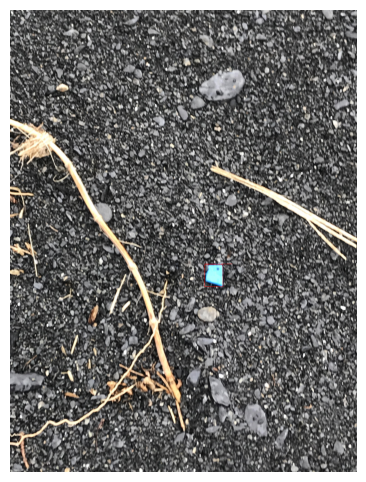

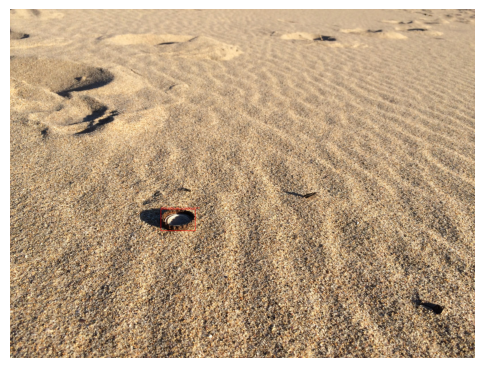

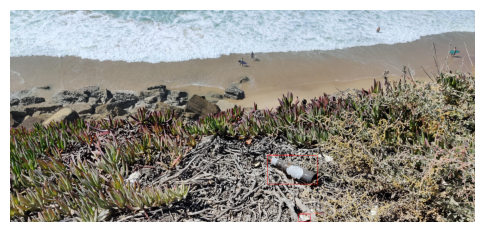

In [73]:

anns_by_img = {}
for ann in coco["annotations"]:
    anns_by_img.setdefault(ann["image_id"], []).append(ann)

def show_random(n=3):
    keys = random.sample(list(anns_by_img.keys()), n)
    for k in keys:
        im = id_to_img[k]
        img_path = IMG_DIR / im["file_name"]
        img = cv2.imread(str(img_path))
        if img is None: 
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        for ann in anns_by_img[k]:
            x,y,bw,bh = ann["bbox"]
            x2,y2 = x+bw, y+bh
            cat_name = id_to_cat[ann["category_id"]]
            mapped   = map_category(cat_name)
            color = (255, 0, 0) if mapped else (150,150,150)
            cv2.rectangle(img, (int(x),int(y)), (int(x2),int(y2)), color, 2)
            label = f"{cat_name} -> {mapped}" if mapped else cat_name
            cv2.putText(img, label[:40], (int(x), max(12,int(y)-4)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        plt.figure(figsize=(6,6)); plt.imshow(img); plt.axis("off"); plt.show()

show_random(3)


In [74]:
valid_image_ids = []

for k, im in id_to_img.items():
    img_path = IMG_DIR / im["file_name"]
    if img_path.exists():
        valid_image_ids.append(k)

print(f"Found {len(valid_image_ids)} valid images with existing files.")



Found 1500 valid images with existing files.


In [75]:
missing = []
for k, im in id_to_img.items():
    img_path = IMG_DIR / im["file_name"]
    if not img_path.exists():
        missing.append(img_path)
        
print(f"{len(missing)} images missing out of {len(id_to_img)}")


0 images missing out of 1500


In [80]:
final_map = {}
for c in coco["categories"]:
    src = c["name"]
    dst = map_category(src)
    final_map[src] = dst  # can be None (meaning: drop this category)

from pathlib import Path
out_path = Path("../data/scripts")
out_path.mkdir(parents=True, exist_ok=True)

map_path = out_path / "class_map.json"
map_path.write_text(json.dumps(final_map, indent=2))
map_path


WindowsPath('../data/scripts/class_map.json')

In [81]:
import json
from pathlib import Path

with open("../data/scripts/class_map.json") as f:   # adjust path if needed
    class_map = json.load(f)

print(type(class_map))   # should be dict
print(list(class_map.items())[:10])  # first 10 mappings


<class 'dict'>
[('Aluminium foil', None), ('Battery', None), ('Aluminium blister pack', None), ('Carded blister pack', None), ('Other plastic bottle', 'plastic_bottle'), ('Clear plastic bottle', 'plastic_bottle'), ('Glass bottle', 'glass_bottle'), ('Plastic bottle cap', 'plastic_bottle'), ('Metal bottle cap', 'plastic_bottle'), ('Broken glass', None)]
